# Cross-Selling of Credit Cards
**Author**: Nils Fahrni

In [1]:
import numpy as np
import sys
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
plt.style.use('ggplot')

pio.templates.default = 'ggplot2'
pd.set_option('display.max_columns', None)

sys.path.append('scripts')
from dataloader import DataLoader

## Data Preprocessing

### Data Loading

In [2]:
data_loader = DataLoader(base_path='data', translations_name='translation_mappings.json')
data_loader.list_datasets()

,Dataset,Number of Rows
0,loan,682
1,client,5369
2,district,77
3,trans,1056320
4,account,4500
5,card,892
6,order,6471
7,disp,5369


#### Account

In [3]:
account = data_loader.load_csv('account', parse_dates={'date': '%y%m%d'})
account.sample(5)

Mapped frequency:
{
    "POPLATEK MESICNE": "MONTHLY CHARGES",
    "POPLATEK TYDNE": "WEEKLY CHARGES",
    "POPLATEK PO OBRATU": "TRANSACTION CHARGES"
}


,account_id,district_id,frequency,date
650,3720,36,MONTHLY CHARGES,1993-07-30
2581,2335,70,MONTHLY CHARGES,1996-04-04
2074,6400,31,TRANSACTION CHARGES,1995-10-09
4414,3382,23,WEEKLY CHARGES,1997-11-20
820,2849,1,MONTHLY CHARGES,1993-09-16


#### Client

In [4]:
client = data_loader.load_csv('client')

client = client.assign(gender=client['birth_number'].apply(lambda x: 'FEMALE' if int(str(x)[2:4]) > 50 else 'MALE'))

client = client.assign(birth_number=client.apply(lambda x: x['birth_number'] - 5000 if x['gender'] == 'FEMALE' else x['birth_number'], axis=1))

client['birth_number'] = pd.to_datetime(client['birth_number'], format='%y%m%d')
client['birth_date'] = client['birth_number'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 1999 else x)
client.drop('birth_number', axis=1, inplace=True)

client['age'] = (pd.to_datetime('1999-12-31') - client['birth_date']).dt.days // 365

client.sample(5)

,client_id,district_id,gender,birth_date,age
4325,4575,36,FEMALE,1964-09-20,35
2812,2970,55,FEMALE,1922-04-06,77
1721,1826,13,MALE,1937-09-12,62
4968,8568,1,FEMALE,1971-12-03,28
4712,5385,67,MALE,1974-02-01,25


#### Disposition

Removing disponents as the goal is to only advertise to owners. Disponents may be secondary users that have been authorized to use an account. They may be allowed to execute transactions on that account but they are not the authorized owners.

In [5]:
disp = data_loader.load_csv('disp')

disp = disp[disp['type'] != 'DISPONENT']

disp.drop('type', axis=1, inplace=True)

disp.sample(5)

,disp_id,client_id,account_id
1904,2018,2018,1664
5007,9109,9417,7606
3322,3507,3507,2902
1855,1966,1966,1622
1739,1844,1844,1521


#### Permanent Order

In [6]:
order = data_loader.load_csv('order')

order.sample(5)

Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SIPO": "HOUSEHOLD",
    "LEASING": "LEASING",
    "UVER": "LOAN PAYMENT"
}


,order_id,account_id,bank_to,account_to,amount,k_symbol
3295,33049,2475,ST,76343703,804.0,NaN
3682,33468,2750,YZ,25649327,2229.0,NaN
3229,32982,2429,GH,91816699,369.0,NaN
1857,31453,1392,ST,15265077,4216.0,NaN
6376,45326,10711,WX,75319576,85.0,INSURANCE PAYMENT


**Are there Null Values?**

In [7]:
display(order.isnull().sum())

display(order[order['k_symbol'].isnull()].sample(5))

order_id         0
account_id       0
bank_to          0
account_to       0
amount           0
k_symbol      1379
dtype: int64

,order_id,account_id,bank_to,account_to,amount,k_symbol
490,29931,358,ST,65233623,1434.0,NaN
1098,30606,826,YZ,5275464,866.0,NaN
133,29556,96,WX,41707503,2140.0,NaN
3594,33375,2689,UV,36906784,2121.0,NaN
3480,33243,2602,WX,59156989,4073.0,NaN


In [8]:
order['k_symbol'] = order['k_symbol'].fillna('MISSING')

order_pivot = order.pivot_table(index='account_id', columns='k_symbol', values='amount', aggfunc='count', fill_value=0)

order_pivot.sample(5)

k_symbol,HOUSEHOLD,INSURANCE PAYMENT,LEASING,LOAN PAYMENT,MISSING
account_id,,,,,
884,1,0,0,0,0
132,0,0,0,1,0
7184,1,1,0,1,2
9493,1,0,0,1,0
3583,1,0,0,0,0


#### Transaction

TODO: 
- amount to negative or positive based on if withdrawal or deposit
- Research account number 19 (time series account balance, at least per month)
    - this acc is volatile
    - account's balance goes negative sometimes
- what happens to accounts with multiple transactions on a day?
    - how to obtain the actual end of day balance?
        - add up withdrawals with deposits and add to balance of day before 
        - try to vectorize this problem (R antijoin mentioned)

In [9]:
transaction = data_loader.load_csv('trans', parse_dates={'date': '%y%m%d'})

transaction.sample(5)

Mapped type:
{
    "PRIJEM": "CREDIT",
    "VYDAJ": "WITHDRAWAL"
}
Mapped operation:
{
    "VYBER KARTOU": "CREDIT CARD WITHDRAWAL",
    "VKLAD": "CREDIT IN CASH",
    "PREVOD Z UCTU": "COLLECTION FROM ANOTHER BANK",
    "VYBER": "WITHDRAWAL IN CASH",
    "PREVOD NA UCET": "REMITTANCE TO ANOTHER BANK"
}
Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SLUZBY": "PAYMENT FOR STATEMENT",
    "UROK": "INTEREST CREDITED",
    "SANKC. UROK": "SANCTION INTEREST IF NEGATIVE BALANCE",
    "SIPO": "HOUSEHOLD",
    "DUCHOD": "OLD-AGE PENSION",
    "UVER": "LOAN PAYMENT"
}


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
968783,414995,1410,1998-09-14,WITHDRAWAL,REMITTANCE TO ANOTHER BANK,3816.0,89910.1,HOUSEHOLD,KL,63791805.0
905863,2908288,9633,1998-07-04,WITHDRAWAL,WITHDRAWAL IN CASH,9600.0,25395.9,NaN,NaN,NaN
1041363,5300,22,1998-12-10,WITHDRAWAL,REMITTANCE TO ANOTHER BANK,6352.0,11809.0,HOUSEHOLD,ST,34691494.0
274450,996552,3402,1996-02-02,CREDIT,CREDIT IN CASH,32291.0,72334.6,NaN,NaN,NaN
322230,1045563,3575,1996-05-25,WITHDRAWAL,WITHDRAWAL IN CASH,3200.0,37000.9,NaN,NaN,NaN


#### Loan

In [10]:
loan = data_loader.load_csv('loan', parse_dates={'date': '%y%m%d'})

loan.sample(5)

Mapped status:
{
    "A": "contract finished, no problems",
    "B": "contract finished, loan not payed",
    "C": "running contract, OK so far",
    "D": "running contract, client in debt"
}


,loan_id,account_id,date,amount,duration,payments,status
303,6921,9422,1996-10-29,86184,12,7182.0,"contract finished, no problems"
14,5523,2705,1993-12-08,93888,36,2608.0,"contract finished, no problems"
445,5389,2165,1997-08-22,78600,24,3275.0,"running contract, OK so far"
576,6464,7156,1998-04-16,49488,24,2062.0,"running contract, OK so far"
469,6355,6699,1997-09-24,127200,48,2650.0,"running contract, OK so far"


**Can an account have multiple loans?**

In [11]:
print(f'Are there accounts with multiple loans: {loan["account_id"].nunique() < loan.shape[0]}')

Are there accounts with multiple loans: False


#### Credit Card

In [12]:
card = data_loader.load_csv('card', parse_dates={'issued': '%y%m%d'})

card.sample(5)

,card_id,disp_id,type,issued
800,693,4495,junior,1998-11-03
672,1003,9274,classic,1998-08-09
65,98,537,classic,1995-09-06
61,592,3782,junior,1995-08-07
117,600,3829,classic,1996-05-20


#### District

In [13]:
district = data_loader.load_csv('district')

district = district.rename(columns={
    'A1': 'district_id',
    'A2': 'district_name',
    'A3': 'region',
    'A4': 'population',
    'A5': 'n_municipalities_with_inhabitants_lt_499',
    'A6': 'n_municipalities_with_inhabitants_500_to_1999',
    'A7': 'n_municipalities_with_inhabitants_2000_to_9999',
    'A8': 'n_municipalities_with_inhabitants_gt_10000',
    'A9': 'n_cities',
    'A10': 'ratio_urban_inhabitants',
    'A11': 'average_salary',
    'A12': 'unemployment_rate_95',
    'A13': 'unemployment_rate_96',
    'A14': 'enterpreneurs_per_1000_inhabitants',
    'A15': 'n_commited_crimes_95',
    'A16': 'n_commited_crimes_96'
})

district.sample(5)

,district_id,district_name,region,population,n_municipalities_with_inhabitants_lt_499,n_municipalities_with_inhabitants_500_to_1999,n_municipalities_with_inhabitants_2000_to_9999,n_municipalities_with_inhabitants_gt_10000,n_cities,ratio_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,enterpreneurs_per_1000_inhabitants,n_commited_crimes_95,n_commited_crimes_96
57,58,Jihlava,south Moravia,109164,98,16,6,1,4,63.6,8757,3.38,3.95,96,2212,2471
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
13,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604,6295
46,47,Pardubice,east Bohemia,162580,83,26,5,1,6,72.8,9538,1.51,1.81,111,6079,5410
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433


### Data Merging

In [14]:
from utils import add_prefix_except_id

account = add_prefix_except_id(account, 'account_', id_exceptions=['district_id'])
client_df = disp.merge(account, on='account_id', how='left')

client = add_prefix_except_id(client, 'client_', id_exceptions=['district_id'])
client_df = client_df.merge(client, on='client_id', how='left')

order_pivot = add_prefix_except_id(order_pivot, 'ordertype_')
client_df = client_df.merge(order_pivot, on='account_id', how='left')

loan = add_prefix_except_id(loan, 'loan_')
client_df = client_df.merge(loan, on='account_id', how='left')

card = add_prefix_except_id(card, 'card_')
client_df = client_df.merge(card, on='disp_id', how='left')

client_district = add_prefix_except_id(district, 'client_district_')
client_df = client_df.merge(client_district, left_on='client_district_id', right_on='district_id', how='left')

account_district = add_prefix_except_id(district, 'account_district_')
client_df = client_df.merge(account_district, left_on='account_district_id', right_on='district_id', how='left')

client_df.sample(5)

n_merged_base_client = client_df.shape[0]

In [15]:
assert client_df['account_id'].nunique() == client_df.shape[0]

### Data Cleaning

#### Removing Junior Cards

In [16]:
junior_clients = client_df[client_df['card_type'] == 'junior']

client_df = client_df[~client_df['account_id'].isin(junior_clients['account_id'])]

transaction = transaction[~transaction['account_id'].isin(junior_clients['account_id'])]

client_df['has_card'] = client_df['card_id'].notnull()

print(f'Number of junior clients: {junior_clients.shape[0]}')
print(f'Number of clients remaining: {client_df.shape[0]}')

Number of junior clients: 145
Number of clients remaining: 4355


## Model Construction

### Processing Transactional Data
- The goal is to predict if a non-card-owner will buy a card or not

The first task is to look if every account in the transactions dataframe has a "first transaction". This would make the calculation of the monthly balance much easier since everything can be summed up without having to worry that there were months without records in the transaction dataframe.

In [17]:
# Find the minimum (first) transaction(s) date for each account
min_dates = transaction.groupby('account_id')['date'].min().reset_index()
min_dates.rename(columns={'date': 'min_date'}, inplace=True)

# Merge the minimum date back to the transactions to identify all transactions on the first day
transactions_with_min_date = pd.merge(transaction, min_dates, on='account_id')

# Filter transactions that are on the first day
first_day_transactions = transactions_with_min_date[transactions_with_min_date['date'] == transactions_with_min_date['min_date']]
first_day_transactions = first_day_transactions.copy()

# Now, for each of these first day transactions, check if any have amount equals balance
first_day_transactions['amount_equals_balance'] = first_day_transactions['amount'] == first_day_transactions['balance']

# Group by account_id and check if any transactions for each account meet the condition
accounts_meeting_condition = first_day_transactions.groupby('account_id')['amount_equals_balance'].any().reset_index()

# Verify if all accounts have at least one transaction on the first day meeting the condition
all_accounts_covered = accounts_meeting_condition['amount_equals_balance'].all()

print("Does every account's first day of transactions include at least one transaction where amount equals balance?", all_accounts_covered)

Does every account's first day of transactions include at least one transaction where amount equals balance? True


Now every accounts balance needs to be calculated per month.

In [18]:
transaction['month'] = transaction['date'].dt.to_period('M')

transactions_monthly = transaction.groupby(['account_id', 'month']).agg(
    volume=('amount', 'sum'),
    credit=('amount', lambda x: x[x > 0].sum()),
    withdrawal=('amount', lambda x: x[x < 0].sum()),
    n_transactions=('amount', 'size')
).reset_index()

In [19]:
transactions_monthly['month'] = pd.PeriodIndex(transactions_monthly['month'])

date_ranges = transactions_monthly.groupby('account_id')['month'].agg(['min', 'max'])

def reindex_df(group, account_id):
    idx = pd.period_range(start=group['month'].min(), end=group['month'].max(), freq='M')
    group.set_index('month', inplace=True)
    group = group.reindex(idx, fill_value=0)
    group.reset_index(inplace=True)
    group.rename(columns={'index': 'month'}, inplace=True)
    group['account_id'] = account_id
    return group

transactions_monthly = (transactions_monthly.groupby('account_id')
                        .apply(lambda x: reindex_df(x, x.name))
                        .reset_index(level=0, drop=True))

# Calculate cumulative balance
transactions_monthly['balance'] = transactions_monthly.groupby('account_id')['volume'].cumsum()

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_44820/3639110262.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: reindex_df(x, x.name))


In [20]:
transactions_monthly

,month,account_id,volume,credit,withdrawal,n_transactions,balance
0,1995-03,1,1000.0,1000.0,0.0,1,1000.0
1,1995-04,1,16298.2,16298.2,0.0,3,17298.2
2,1995-05,1,5858.0,5858.0,0.0,3,23156.2
3,1995-06,1,3979.6,3979.6,0.0,3,27135.8
4,1995-07,1,9087.9,9087.9,0.0,3,36223.7
...,...,...,...,...,...,...,...
36,1998-08,11382,54569.5,54569.5,0.0,7,2386853.6
37,1998-09,11382,44120.0,44120.0,0.0,5,2430973.6
38,1998-10,11382,63262.2,63262.2,0.0,6,2494235.8
39,1998-11,11382,50165.7,50165.7,0.0,5,2544401.5


### Defining Roll-Up Windows of Transactions

Before we can continue to filter out customers that have at least 13 Months of transaction history it is also needed to give non-customers a fictional `card_issued` date so we can build negative samples that also contain a 13-Month rollup window.

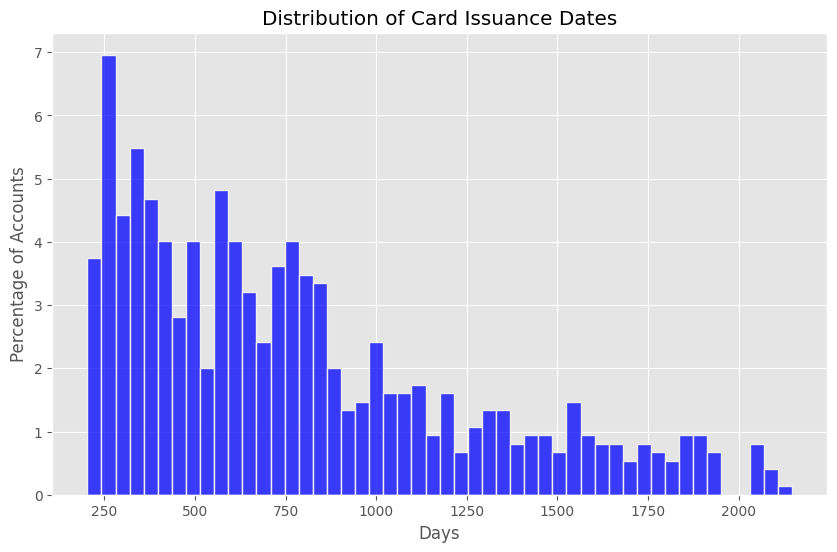

In [21]:
clients_with_cards = client_df[~client_df['card_issued'].isnull()]
time_between_creation_and_issue = (clients_with_cards['card_issued'] - clients_with_cards['account_date']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='blue', linewidth=1)

plt.title('Distribution of Card Issuance Dates')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.grid(True)

plt.show()

An observation we can make when looking at the distribution of when cards usually get issued after the account creation is that there don't seem to be any issuances before day 200 of the account.

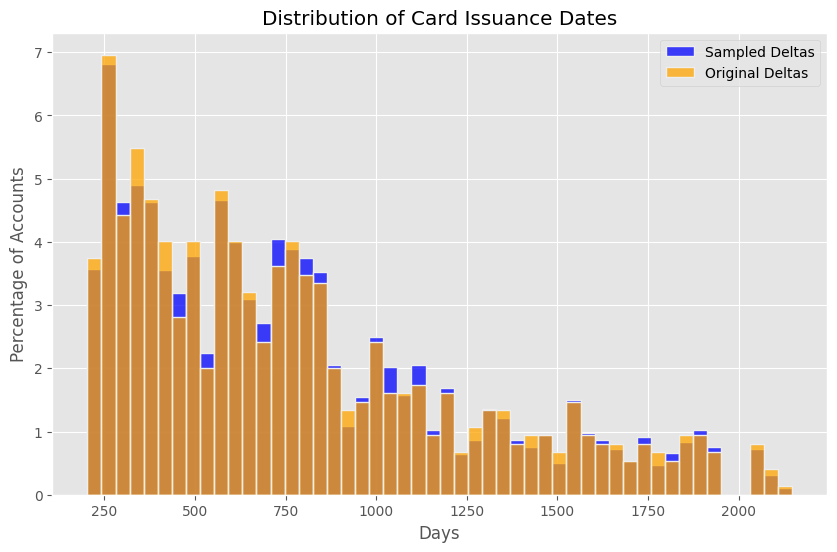

In [22]:
np.random.seed(1337)

sampled_deltas = np.random.choice(time_between_creation_and_issue, size=len(client_df[client_df['card_issued'].isnull()]))

plt.figure(figsize=(10, 6))
sns.histplot(sampled_deltas, bins=50, stat='percent', kde=False, color='blue', linewidth=1, label='Sampled Deltas')
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='orange', linewidth=1, label='Original Deltas')

plt.title('Distribution of Card Issuance Dates')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.legend()
plt.grid(True)

plt.show()

In [23]:
if len(client_df[client_df['card_issued'].isnull()]) > 0:
    client_df.loc[client_df['card_issued'].isnull(), 'card_issued'] = client_df.loc[client_df['card_issued'].isnull(), 'account_date'] + pd.to_timedelta(sampled_deltas, unit='D')
    
print(f'Number of NaT/NaN values in card_issued: {client_df["card_issued"].isnull().sum()}')

Number of NaT/NaN values in card_issued: 0


In [24]:
card_issued = card.groupby('disp_id')['card_issued'].min().reset_index()
card_issued.head(5)

,disp_id,card_issued
0,9,1998-10-16
1,19,1998-03-13
2,41,1995-09-03
3,42,1998-11-26
4,51,1995-04-24


In [25]:
client_df[client_df['disp_id'].isnull()].shape[0]

transactions_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179054 entries, 0 to 40
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype    
---  ------          --------------   -----    
 0   month           179054 non-null  period[M]
 1   account_id      179054 non-null  int64    
 2   volume          179054 non-null  float64  
 3   credit          179054 non-null  float64  
 4   withdrawal      179054 non-null  float64  
 5   n_transactions  179054 non-null  int64    
 6   balance         179054 non-null  float64  
dtypes: float64(4), int64(2), period[M](1)
memory usage: 10.9 MB


In [26]:
transactions_monthly = transactions_monthly.merge(client_df[['account_id', 'card_issued']], left_on='account_id', right_on='account_id', how='left')

transactions_monthly.head()

,month,account_id,volume,credit,withdrawal,n_transactions,balance,card_issued
0,1995-03,1,1000.0,1000.0,0.0,1,1000.0,1998-09-18
1,1995-04,1,16298.2,16298.2,0.0,3,17298.2,1998-09-18
2,1995-05,1,5858.0,5858.0,0.0,3,23156.2,1998-09-18
3,1995-06,1,3979.6,3979.6,0.0,3,27135.8,1998-09-18
4,1995-07,1,9087.9,9087.9,0.0,3,36223.7,1998-09-18


Now, let's see if the join worked correctly and we don't have any transactions without a `card_issued` date anymore.

In [27]:
assert transactions_monthly['card_issued'].isnull().sum() == 0

### Validating Negative Examples
The goal for our model will be to be able to learn from a base set of customers (with and without cards) that lived through the same economic circumstances. To validate that all customers in our current set are represented in a well distributed way, this next plot looks at the distribution of volume throughout the datasets timeframe.

In [28]:
transactions_monthly['has_card'] = transactions_monthly['account_id'].isin(client_df[client_df['has_card']]['account_id'])

In [29]:
transactions_monthly.reset_index(inplace=True)
transactions_monthly['id'] = range(len(transactions_monthly))
transactions_monthly.set_index('id', inplace=True)

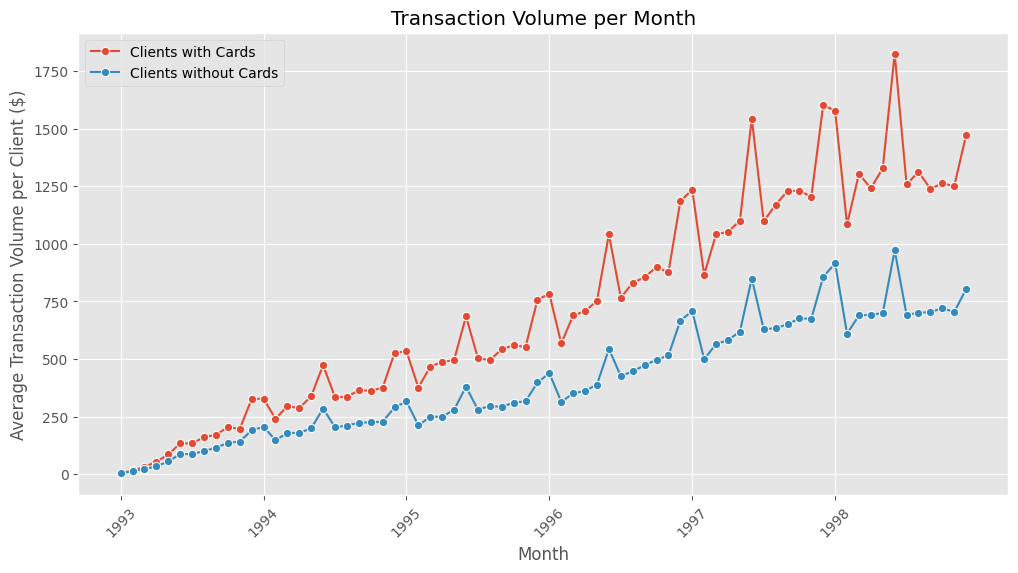

In [30]:
transactions_with_cards = transactions_monthly[transactions_monthly['has_card'] == True]
transactions_without_cards = transactions_monthly[transactions_monthly['has_card'] == False]

grouped_with_cards = transactions_with_cards.groupby('month')['volume'].sum().reset_index()
grouped_without_cards = transactions_without_cards.groupby('month')['volume'].sum().reset_index()

grouped_with_cards['month'] = grouped_with_cards['month'].astype(str)
grouped_without_cards['month'] = grouped_without_cards['month'].astype(str)

grouped_with_cards['avg_volume_per_client'] = grouped_with_cards['volume'] / transactions_with_cards.shape[0]
grouped_without_cards['avg_volume_per_client'] = grouped_without_cards['volume'] / transactions_without_cards.shape[0]

plt.figure(figsize=(12, 6))

sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_with_cards, marker='o', label='Clients with Cards')
sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_without_cards, marker='o', label='Clients without Cards')

plt.title('Transaction Volume per Month')
plt.xlabel('Month')
plt.ylabel('Average Transaction Volume per Client ($)')
plt.legend()
plt.grid(True)

plt.xticks(ticks=grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')], rotation=45)
plt.gca().set_xticklabels([label[:4] for label in grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')]])

plt.show()


In [31]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])
transactions_monthly['card_issued_period'] = transactions_monthly['card_issued'].dt.to_period('M')

transactions_monthly['month_diff'] = transactions_monthly.apply(lambda row: (row['card_issued_period'] - row['month']).n if pd.notnull(row['card_issued_period']) and pd.notnull(row['month']) else None, axis=1)

filtered_transactions = transactions_monthly[transactions_monthly['month_diff'].between(1, 13)]

In [32]:
transactions_monthly

,index,month,account_id,volume,credit,withdrawal,n_transactions,balance,card_issued,has_card,card_issued_period,month_diff
id,,,,,,,,,,,,
0,0,1995-03,1,1000.0,1000.0,0.0,1,1000.0,1998-09-18,False,1998-09,42
1,1,1995-04,1,16298.2,16298.2,0.0,3,17298.2,1998-09-18,False,1998-09,41
2,2,1995-05,1,5858.0,5858.0,0.0,3,23156.2,1998-09-18,False,1998-09,40
3,3,1995-06,1,3979.6,3979.6,0.0,3,27135.8,1998-09-18,False,1998-09,39
4,4,1995-07,1,9087.9,9087.9,0.0,3,36223.7,1998-09-18,False,1998-09,38
...,...,...,...,...,...,...,...,...,...,...,...,...
179049,179049,1998-08,11382,54569.5,54569.5,0.0,7,2386853.6,1996-09-30,False,1996-09,-23
179050,179050,1998-09,11382,44120.0,44120.0,0.0,5,2430973.6,1996-09-30,False,1996-09,-24
179051,179051,1998-10,11382,63262.2,63262.2,0.0,6,2494235.8,1996-09-30,False,1996-09,-25


In [33]:
filtered_transactions.sort_values(by=['account_id', 'month_diff'])

,index,month,account_id,volume,credit,withdrawal,n_transactions,balance,card_issued,has_card,card_issued_period,month_diff
id,,,,,,,,,,,,
41,41,1998-08,1,6492.7,6492.7,0.0,5,338855.2,1998-09-18,False,1998-09,1
40,40,1998-07,1,6221.0,6221.0,0.0,4,332362.5,1998-09-18,False,1998-09,2
39,39,1998-06,1,6667.1,6667.1,0.0,5,326141.5,1998-09-18,False,1998-09,3
38,38,1998-05,1,6212.3,6212.3,0.0,4,319474.4,1998-09-18,False,1998-09,4
37,37,1998-04,1,7435.5,7435.5,0.0,6,313262.1,1998-09-18,False,1998-09,5
...,...,...,...,...,...,...,...,...,...,...,...,...
179017,179017,1995-12,11382,82563.6,82563.6,0.0,4,221665.9,1996-09-30,False,1996-09,9
179016,179016,1995-11,11382,51280.6,51280.6,0.0,4,139102.3,1996-09-30,False,1996-09,10
179015,179015,1995-10,11382,49912.3,49912.3,0.0,4,87821.7,1996-09-30,False,1996-09,11


#### Pivoting the transactions

An issue at this point can be that an account may have months without any transactions, so there needs to be a more thorough process to interpolate the data:
- **Volume, Withdrawal, Credit and Number of Transactions**: If there are missing months in these variables we can just set `0` as their value as there has not been any activity if there were no recorded months.
- **Balance**: The balance will get recursively set to the last preceding recorded month. So if there are consecutive "missing" months in transactions the balance will always be set to the last recorded month.

In [34]:
account_summary = pd.DataFrame(filtered_transactions['account_id'].unique(), columns=['account_id'])

variables_to_pivot = ['volume', 'withdrawal', 'credit', 'n_transactions', 'balance']

for variable in variables_to_pivot:
    grouped = filtered_transactions.groupby(['account_id', 'month_diff'])[variable].sum().reset_index()
    pivot = grouped.pivot(index='account_id', columns='month_diff', values=variable).reset_index()
    pivot.columns = ['account_id'] + [f'{variable}_month_diff_{int(col)}' if col != 'account_id' else 'account_id' for col in pivot.columns[1:]]
    account_summary = pd.merge(account_summary, pivot, on='account_id', how='left')

for variable in ['volume', 'withdrawal', 'credit', 'n_transactions']:
    account_summary.update(account_summary.filter(regex=f'^{variable}_').fillna(0))

def find_last_balance(account_id, starting_month_diff):
    higher_month_diff = transactions_monthly[
        (transactions_monthly['account_id'] == account_id) & 
        (transactions_monthly['month_diff'] >= starting_month_diff)
    ].sort_values('month_diff')
    
    last_balance_row = higher_month_diff[higher_month_diff['balance'].notna()].head(1)
    
    if not last_balance_row.empty:
        return last_balance_row.iloc[0]['balance']
    else:
        return 0

balance_columns = [col for col in account_summary.columns if 'balance_month_diff_' in col]
for idx, row in account_summary.iterrows():
    for col in balance_columns:
        if pd.isna(row[col]):
            month_diff = int(col.split('_')[-1])
            last_balance = find_last_balance(row['account_id'], month_diff + 1)
            account_summary.at[idx, col] = last_balance

In [35]:
account_summary.head()

,account_id,volume_month_diff_1,volume_month_diff_2,volume_month_diff_3,volume_month_diff_4,volume_month_diff_5,volume_month_diff_6,volume_month_diff_7,volume_month_diff_8,volume_month_diff_9,volume_month_diff_10,volume_month_diff_11,volume_month_diff_12,volume_month_diff_13,withdrawal_month_diff_1,withdrawal_month_diff_2,withdrawal_month_diff_3,withdrawal_month_diff_4,withdrawal_month_diff_5,withdrawal_month_diff_6,withdrawal_month_diff_7,withdrawal_month_diff_8,withdrawal_month_diff_9,withdrawal_month_diff_10,withdrawal_month_diff_11,withdrawal_month_diff_12,withdrawal_month_diff_13,credit_month_diff_1,credit_month_diff_2,credit_month_diff_3,credit_month_diff_4,credit_month_diff_5,credit_month_diff_6,credit_month_diff_7,credit_month_diff_8,credit_month_diff_9,credit_month_diff_10,credit_month_diff_11,credit_month_diff_12,credit_month_diff_13,n_transactions_month_diff_1,n_transactions_month_diff_2,n_transactions_month_diff_3,n_transactions_month_diff_4,n_transactions_month_diff_5,n_transactions_month_diff_6,n_transactions_month_diff_7,n_transactions_month_diff_8,n_transactions_month_diff_9,n_transactions_month_diff_10,n_transactions_month_diff_11,n_transactions_month_diff_12,n_transactions_month_diff_13,balance_month_diff_1,balance_month_diff_2,balance_month_diff_3,balance_month_diff_4,balance_month_diff_5,balance_month_diff_6,balance_month_diff_7,balance_month_diff_8,balance_month_diff_9,balance_month_diff_10,balance_month_diff_11,balance_month_diff_12,balance_month_diff_13
0,1,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6492.7,6221.0,6667.1,6212.3,7435.5,7018.6,6701.9,9091.5,10907.2,7318.0,6218.0,6600.6,8282.7,5.0,4.0,5.0,4.0,6.0,5.0,5.0,10.0,5.0,5.0,4.0,5.0,6.0,338855.2,332362.5,326141.5,319474.4,313262.1,305826.6,298808.0,292106.1,283014.6,272107.4,264789.4,258571.4,251970.8
1,2,34617.6,45943.4,52856.1,47098.6,52913.9,37980.7,31345.5,23949.5,1100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34617.6,45943.4,52856.1,47098.6,52913.9,37980.7,31345.5,23949.5,1100.0,0.0,0.0,0.0,0.0,6.0,7.0,7.0,6.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,327805.3,293187.7,247244.3,194388.2,147289.6,94375.7,56395.0,25049.5,1100.0,0.0,0.0,0.0,0.0
2,4,10917.6,12013.8,9011.7,14254.5,11343.0,9015.0,10769.2,9003.4,20249.4,13529.7,9040.6,9031.2,12329.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10917.6,12013.8,9011.7,14254.5,11343.0,9015.0,10769.2,9003.4,20249.4,13529.7,9040.6,9031.2,12329.5,6.0,6.0,5.0,6.0,7.0,5.0,6.0,5.0,12.0,7.0,5.0,5.0,6.0,195475.7,184558.1,172544.3,163532.6,149278.1,137935.1,128920.1,118150.9,109147.5,88898.1,75368.4,66327.8,57296.6
3,5,8607.1,7797.2,15720.3,10825.1,7812.5,5035.1,5017.0,5017.0,5017.0,5017.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8607.1,7797.2,15720.3,10825.1,7812.5,5035.1,5017.0,5017.0,5017.0,5017.0,600.0,0.0,0.0,5.0,4.0,10.0,6.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,76465.3,67858.2,60061.0,44340.7,33515.6,25703.1,20668.0,15651.0,10634.0,5617.0,600.0,0.0,0.0
4,6,14333.0,10810.0,10798.3,11989.9,20888.8,13055.1,10807.0,13039.2,10792.4,23857.9,11865.2,10815.6,10803.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14333.0,10810.0,10798.3,11989.9,20888.8,13055.1,10807.0,13039.2,10792.4,23857.9,11865.2,10815.6,10803.9,5.0,4.0,4.0,5.0,6.0,5.0,4.0,5.0,4.0,11.0,6.0,4.0,4.0,625481.9,611148.9,600338.9,589540.6,577550.7,556661.9,543606.8,532799.8,519760.6,508968.2,485110.3,473245.1,462429.5


In [36]:
client_df = client_df.merge(account_summary, on='account_id', how='inner')

### Bringing the data together

In [37]:
n_lt_13_month_hist = transactions_monthly['account_id'].nunique()-filtered_transactions['account_id'].nunique()

preprocessing_summary = [
        n_merged_base_client,
        -len(junior_clients),
        -n_lt_13_month_hist,
        #-len(non_card_owners)+len(matched_non_buyers_df),
        -len(client_df)
]

fig = go.Figure(go.Waterfall(
        name = "20", orientation = "v",
        measure = ["absolute", "relative", "relative", "relative", "total"],
        x = ["Base Client List", "Junior Clients", "Clients with less than 13 Months of Transaction History", "Non-Card-Holders that were not matched on account activity", "Remaining Clients"],
        textposition = "outside",
        y = preprocessing_summary,
        text = [str(x) for x in preprocessing_summary],
        connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Profit and loss statement 2018",
        showlegend = True
)

fig.show()

## Exploratory Data Analysis

### Exploring Missing Values

In [38]:
missing_values = client_df.isnull().sum()

missing_values = pd.DataFrame({
    'Number of Missing Values': missing_values[missing_values > 0],
    'Percentage of Missing Values': [
        f"{x:.2f}%" for x in (missing_values[missing_values > 0] / client_df.shape[0] * 100).round(2)
    ]
}, columns=['Number of Missing Values', 'Percentage of Missing Values'])

fig = go.Figure()

fig.add_trace(go.Bar(
    x=missing_values.index,
    y=missing_values['Number of Missing Values'],
    text=missing_values['Percentage of Missing Values'],
    textposition='auto'
))

fig.update_layout(
    title='Missing Values in the Dataset',
    xaxis_title='Columns',
    yaxis_title='Number of Missing Values'
)

fig.show()

### Cardholders vs Non-Cardholders

In [39]:
card_owners = client_df[client_df['has_card']]
non_card_owners = client_df[~client_df['has_card']]

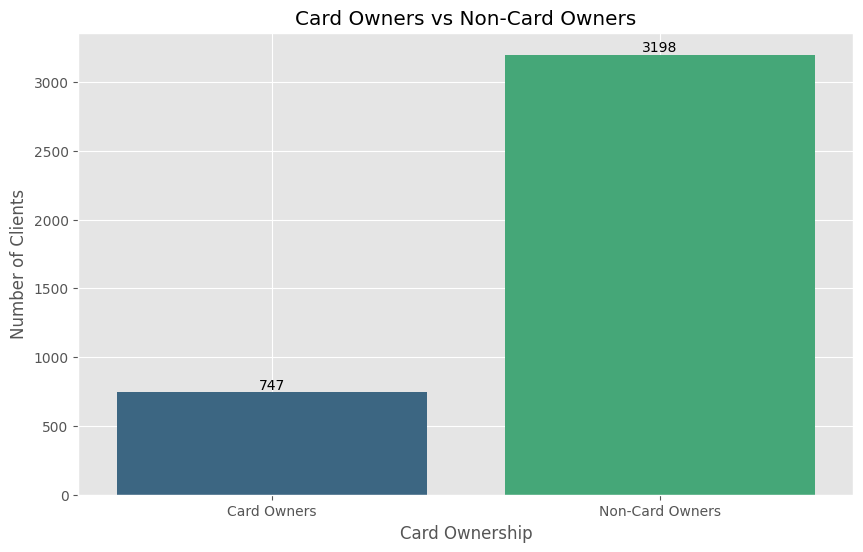

In [40]:
data = {
    'Card Ownership': ['Card Owners', 'Non-Card Owners'],
    'Number of Clients': [card_owners.shape[0], non_card_owners.shape[0]]
}

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Ownership', y='Number of Clients', data=data, palette='viridis', hue='Card Ownership')

for index, value in enumerate(data['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Owners vs Non-Card Owners')
plt.xlabel('Card Ownership')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()


###  Card Types

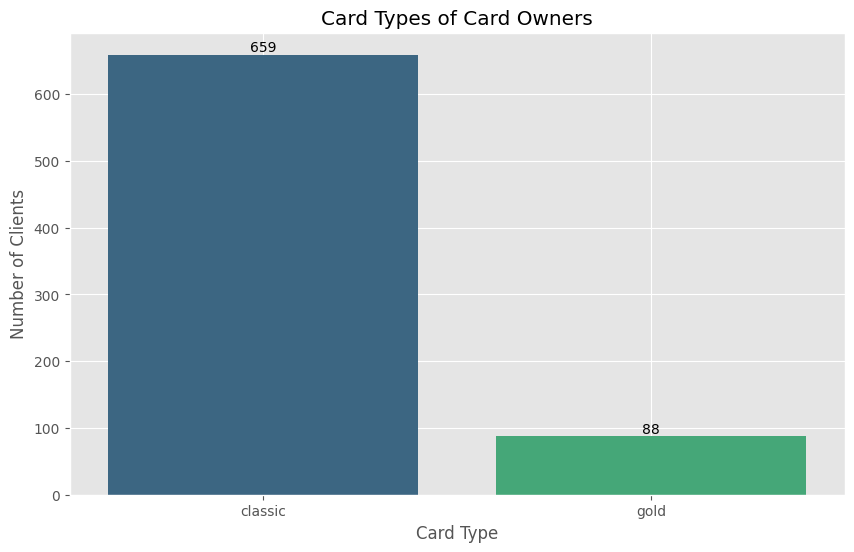

In [41]:
card_types = card_owners['card_type'].value_counts()
card_types = card_types.reset_index()
card_types.columns = ['Card Type', 'Number of Clients']

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Type', y='Number of Clients', data=card_types, palette='viridis', hue='Card Type')

for index, value in enumerate(card_types['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Types of Card Owners')
plt.xlabel('Card Type')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()

### Volume before card purchase

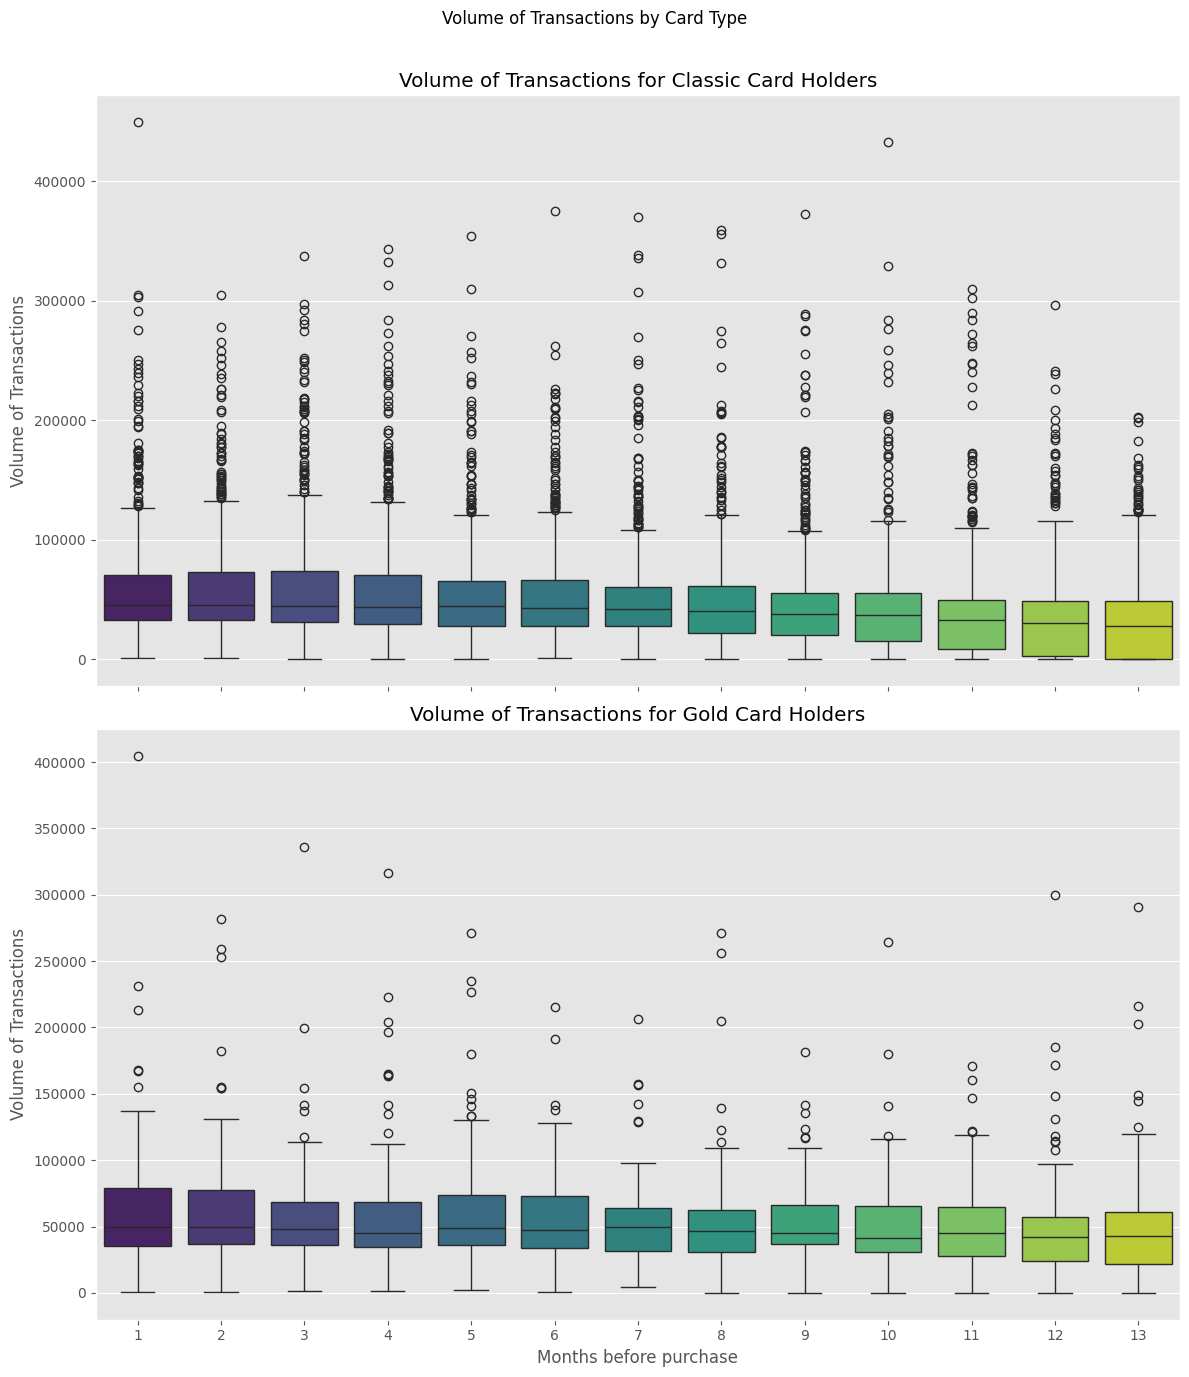

In [42]:
classic_card_type_df = card_owners[card_owners['card_type'] == 'classic']
gold_card_type_df = card_owners[card_owners['card_type'] == 'gold']

volume_month_diff_columns = [col for col in account_summary.columns if 'volume_month_diff_' in col]

classic_data = []
gold_data = []

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in classic_card_type_df[col]:
        classic_data.append({'Month': month_num, 'Volume': value, 'Card Type': 'Classic'})

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in gold_card_type_df[col]:
        gold_data.append({'Month': month_num, 'Volume': value, 'Card Type': 'Gold'})

combined_data = classic_data + gold_data

combined_df = pd.DataFrame(combined_data)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

sns.boxplot(ax=axes[0], x='Month', y='Volume', data=combined_df[combined_df['Card Type'] == 'Classic'], palette='viridis', hue='Month')
axes[0].set_title('Volume of Transactions for Classic Card Holders')
axes[0].set_xlabel('Months before purchase')
axes[0].set_ylabel('Volume of Transactions')

sns.boxplot(ax=axes[1], x='Month', y='Volume', data=combined_df[combined_df['Card Type'] == 'Gold'], palette='viridis', hue='Month')
axes[1].set_title('Volume of Transactions for Gold Card Holders')
axes[1].set_xlabel('Months before purchase')
axes[1].set_ylabel('Volume of Transactions')

fig.suptitle('Volume of Transactions by Card Type')
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

### Age distribution

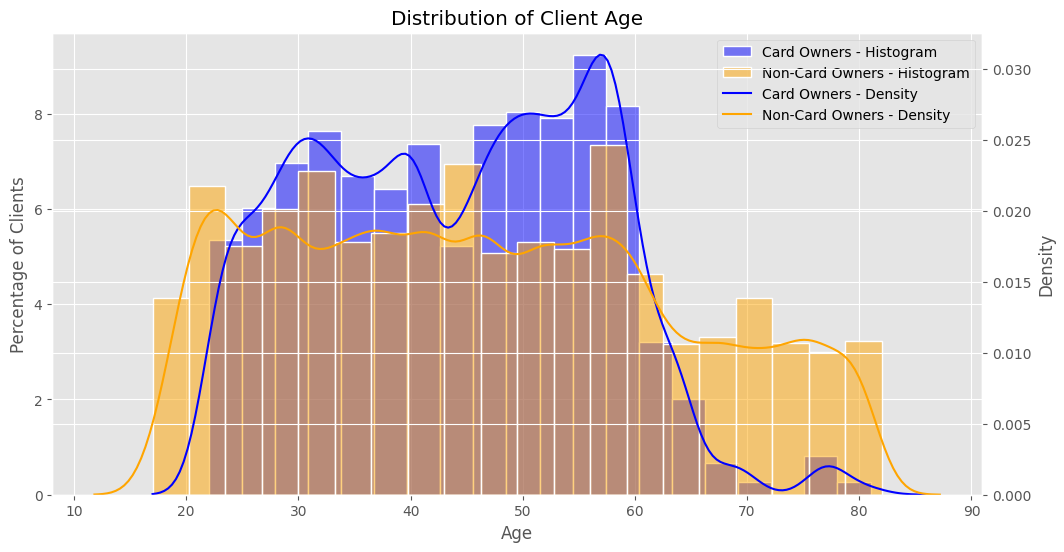

In [43]:
# Assuming card_owners and non_card_owners DataFrames are already defined
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot histograms with percentage normalization on the left y-axis
sns.histplot(card_owners['client_age'], bins=20, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners - Histogram', alpha=0.5, ax=ax1)
sns.histplot(non_card_owners['client_age'], bins=20, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners - Histogram', alpha=0.5, ax=ax1)

# Set up the second y-axis
ax2 = ax1.twinx()

# Plot density plots on the right y-axis
sns.kdeplot(card_owners['client_age'], bw_adjust=0.5, color='blue', label='Card Owners - Density', ax=ax2)
sns.kdeplot(non_card_owners['client_age'], bw_adjust=0.5, color='orange', label='Non-Card Owners - Density', ax=ax2)

# Set the titles and labels
ax1.set_title('Distribution of Client Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percentage of Clients')
ax2.set_ylabel('Density')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

# Show the plot
plt.grid(True)
plt.show()

## Train-Test-Split

In [44]:
from sklearn.model_selection import train_test_split

X = client_df
y = X['has_card']
X = X.drop(columns=['has_card', 'card_id', 'card_issued', 'card_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [45]:
print('Train set:')
print(y_train.value_counts(normalize=True))
print('\nTest set:')
print(y_test.value_counts(normalize=True))

Train set:
has_card
False    0.811787
True     0.188213
Name: proportion, dtype: float64

Test set:
has_card
False    0.806084
True     0.193916
Name: proportion, dtype: float64


## Baseline Model
Erstellen eines Baseline Modelles mittels logistischer Regression und den Informationen “Alter”,
“Geschlecht”, “Domizilregion”, “Vermögen” und “Umsatz” vor Kreditkartenkauf.

In [46]:
from scripts.utils import evaluate_model

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

baseline_column_selection = client_df[['client_age', 'client_gender', 'client_district_region']]
client_vol_bal_cols = client_df.filter(regex='(volume|balance)', axis=1).columns
baseline_column_selection = pd.concat([baseline_column_selection, client_df[client_vol_bal_cols]], axis=1)

baseline_cat_columns = baseline_column_selection.select_dtypes(include=['object'])
baseline_num_columns = baseline_column_selection.select_dtypes(exclude=['object'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), baseline_num_columns.columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), baseline_cat_columns.columns)
    ])

base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

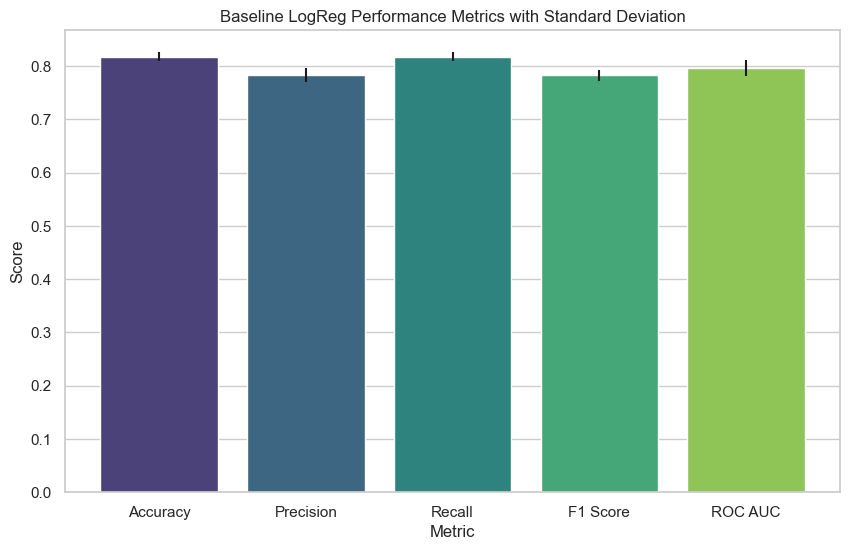

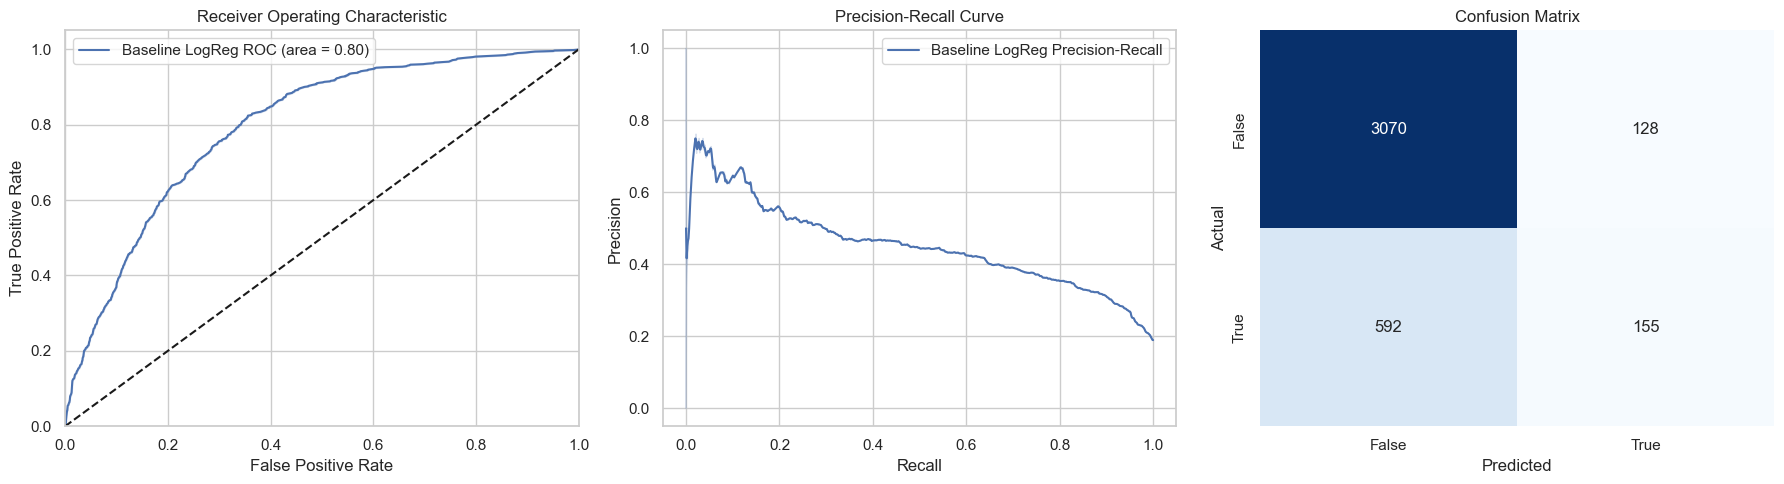

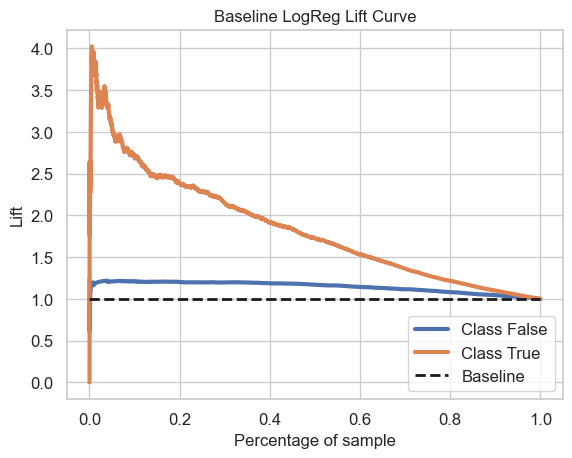

      Metric      Mean       Std
0   Accuracy  0.817490  0.008455
1  Precision  0.783698  0.013294
2     Recall  0.817490  0.008455
3   F1 Score  0.782452  0.009796
4    ROC AUC  0.796111  0.014741


In [48]:
results_df = evaluate_model(pipeline=base_pipeline, X=baseline_column_selection, y=client_df['has_card'], model_name='Baseline LogReg')
print(results_df)

### Generating Event-Based Customer Information

## Feature Engineering

### Deriving New Features